# 3D multi-channel interpolation with local slopes regularization

## Author: M.Ravasi

This notebook applies 3D multi-channel interpolation with local slopes regularization to a 3D shot gather of the SEG/EAGE Overthrust 3D dataset.

The notebook is organized as follows:

- data pre-processing
- multi-channel slope estimation
- 2D single-channel interpolation with sparsity promoting inversion
- 2D multi-channel interpolation with sparsity promoting inversion
- 2D multi-channel interpolation with sparsity promoting inversion and local slopes regularization.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.signal import convolve
from pylops.config import disabled_ndarray_multiplication
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.signalprocessing.patch2d import patch2d_design
from pylops.optimization.leastsquares import regularized_inversion
from pylops.optimization.sparsity import fista
from pylops.utils.wavelets import ricker
from pylops.utils.metrics import snr
from pylops.utils.dottest import dottest

from mcslopes.nmoinv3D import NMO
from mcslopes.plotting import plotting_style, explode_volume
from mcslopes.preprocessing import butter_lowpass_filter, mask, subsample, gradient_data3d, fk_filter_design3d
from mcslopes.slopes import multicomponent_slopes_inverse

plotting_style()
USE_CUPY = True # use cupy or numpy

In [2]:
if USE_CUPY:
    import cupy as cp
    cp_asarray = cp.asarray
    cp_asnumpy = cp.asnumpy
else:
    cp = np
    cp_asarray = np.asarray
    cp_asnumpy = np.asarray

## Parameters

In [3]:
# data
dt = 0.004 # time sampling (in s)
dy, dx = 20, 20 # spatial sampling (in m)
ny, nx, nt = 90, 177, 801 # data size in samples
ys, xs = 46 * dy, 93 * dx # Source location

# pre-processing
fwav = 35. # frequency of ricker wavelet to apply to data (in Hz)
apply_nmo = True # apply NMO correction prior to interpolation (True) or not (False)
vnmo = 2000 # NMO velocity (in m/s)
mask_thresh = 0.005 # time-space mask threshold in percentage of max value of data
nfft_t, nfft_y, nfft_x = 2**10, 2**8, 2**8 # lenght of frequency and wavenumber axis (used to compute gradients and perform FK transforms during data reconstruction)

# fk masking
vel = 1800. # velocity
fmax = 75 # maximum frequency
critical = 1.00 # scaling to be applied to the f=k*v line used to create the mask
koffset = 0.001 # shift to be applied to the f=k*v line used to create the mask

# subsampling
nsub = 5 # subsampling factor

# slope estimation
eps_slopeest = 6e2 # regularization factor for smoothing
niter_slopeest = 400 # number of iterations of lsqr

# interpolation
eps_slopes = 1e1 # regularization factor for slope consistency term
eps_fk = 1e-2 # regularization factor for sparsity term
niter = 200 # number of iterations of fista

## Data loading and preprocessing

We start by loading the data and applying the following pre-processing steps:

- filtering
- direct arrival removal
- time gain
- NMO correction (optional)
- define time-space mask

In [4]:
d = np.fromfile('../../data/dat_full13350.rsf@', dtype='float32')
d = d.reshape(1201, 4, nx * ny)[:nt]
p = d[:, 0].reshape(nt, ny, nx).transpose(1, 2, 0)

y = np.arange(ny) * dy
x = np.arange(nx) * dx
t = np.arange(nt) * dt

# Apply wavelet
wav, _, wav_c = ricker(t[:101], fwav)

p = np.apply_along_axis(convolve, 2, p, wav, mode="full")
p = p[:, :, wav_c:][:, :, :nt]

# Apply gain
gain = t ** 2
p = (p * gain[np.newaxis, np.newaxis, :])

# Normalize
pmax = p.max() * 0.1
p /= pmax

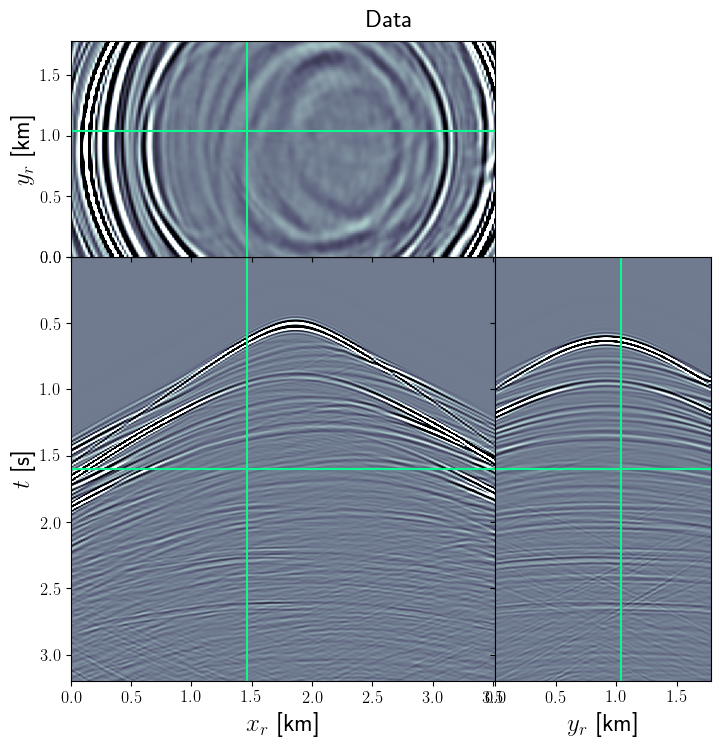

In [5]:
explode_volume(p.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), title='Data');

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


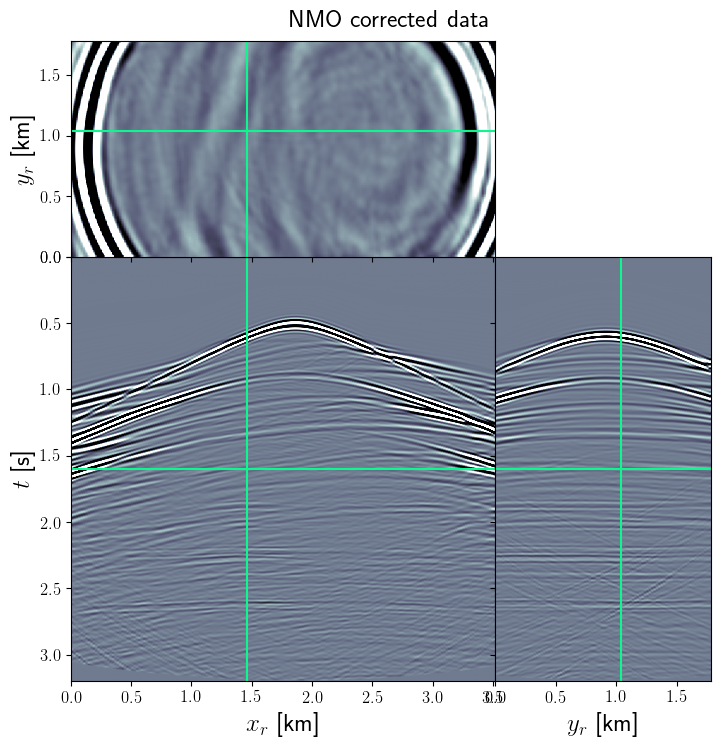

In [6]:
if apply_nmo:
    NMOOp = NMO(t, y-ys, x-xs, vnmo * np.ones(nt))
    
    pnmo = NMOOp @ p

    explode_volume(pnmo.transpose(2,1,0), x=73, y=52,
                   tlim=[0, t[-1]], tlabel=r'$t$',
                   xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
                   ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
                   labels= ('[s]', '[km]', '[km]'),
                   clipval=(-0.5, 0.5), figsize=(8, 8), 
                   title='NMO corrected data')
    
    # Overwrite data with nmo corrected data
    porig = p.copy()
    p = pnmo.copy()

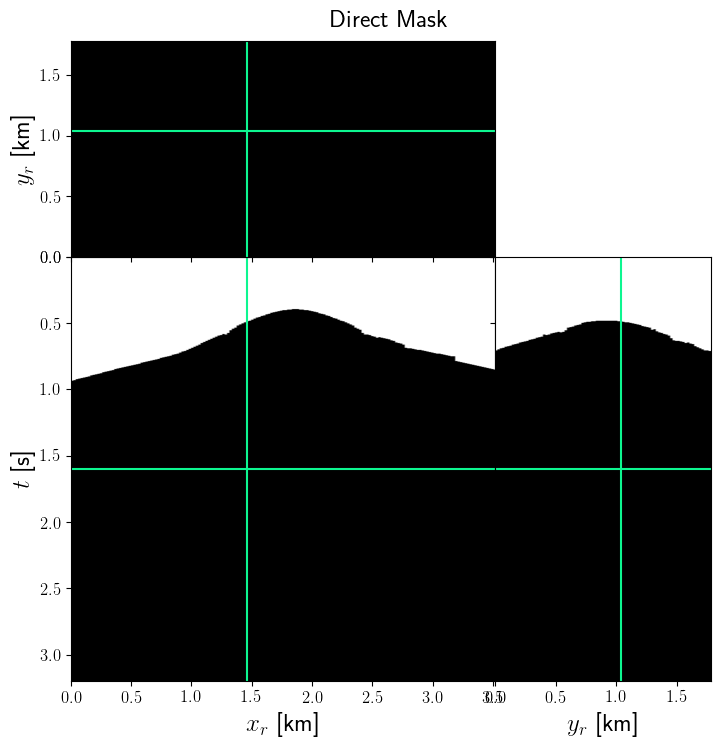

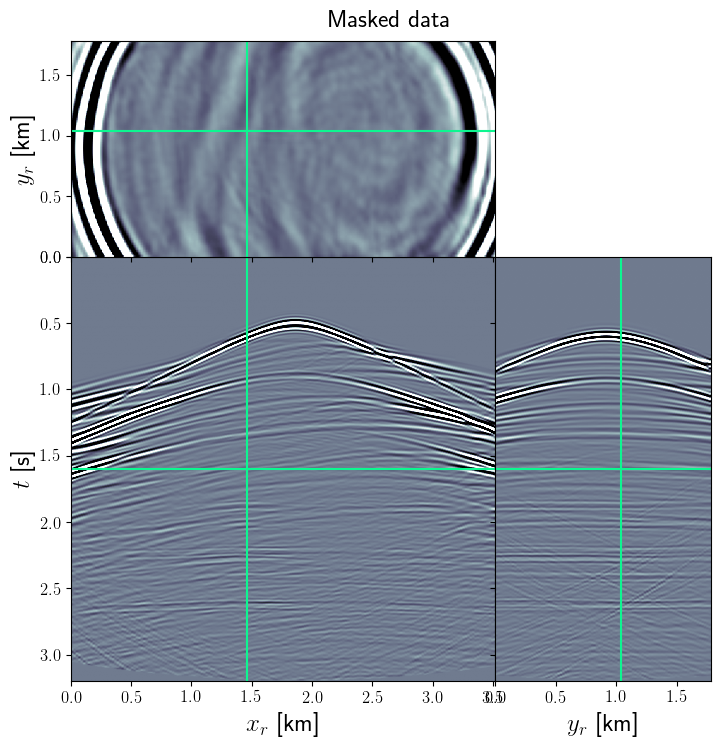

In [7]:
# Calculate time-space mask
direct_mask = mask(p.reshape(ny*nx, nt), mask_thresh * np.max(np.abs(p)), 10).reshape(ny, nx, nt)

explode_volume(direct_mask.transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'), cmap='gray_r',
               clipval=(0, 1), figsize=(8, 8), 
               title='Direct Mask')    
explode_volume((direct_mask*p).transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), title='Masked data');

## Data decimation

We proceed now with defining the subsampling strategy and create the subsampled data we wish to interpolate

Spatial sampling: 100


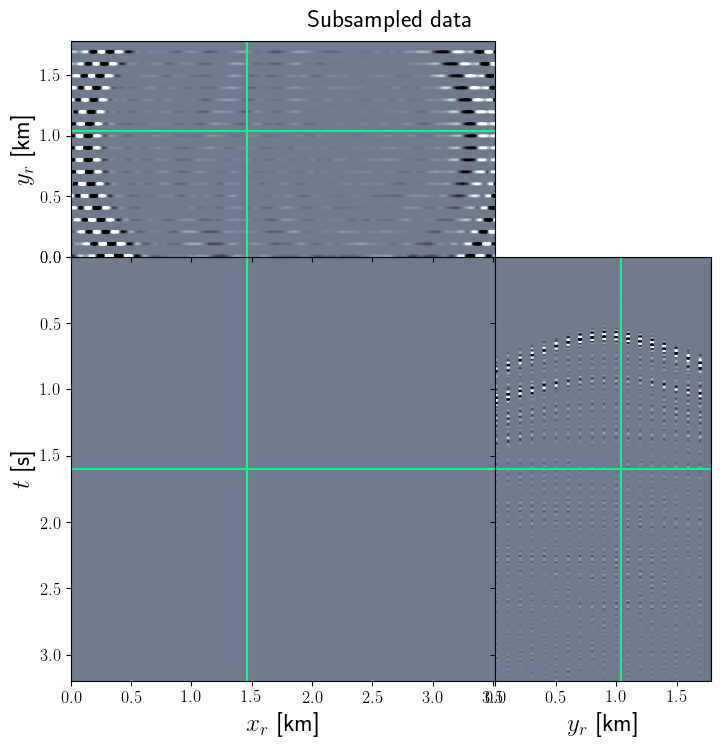

In [8]:
# Create restriction operator
print('Spatial sampling:', dx*nsub)

p_obs, p_mask, Rop = subsample(p, nsub, dtype=np.float32)

explode_volume(p_mask.data.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title='Subsampled data');

## Spatial derivatives

## Spatial derivatives

We are now ready to create the first and second order gradients. In real life, these will be directly acquired and subjected to a similar pre-processing flow of the pressure data (*note: NMO correction must be performed as described in Robertsson et al., 2008*)

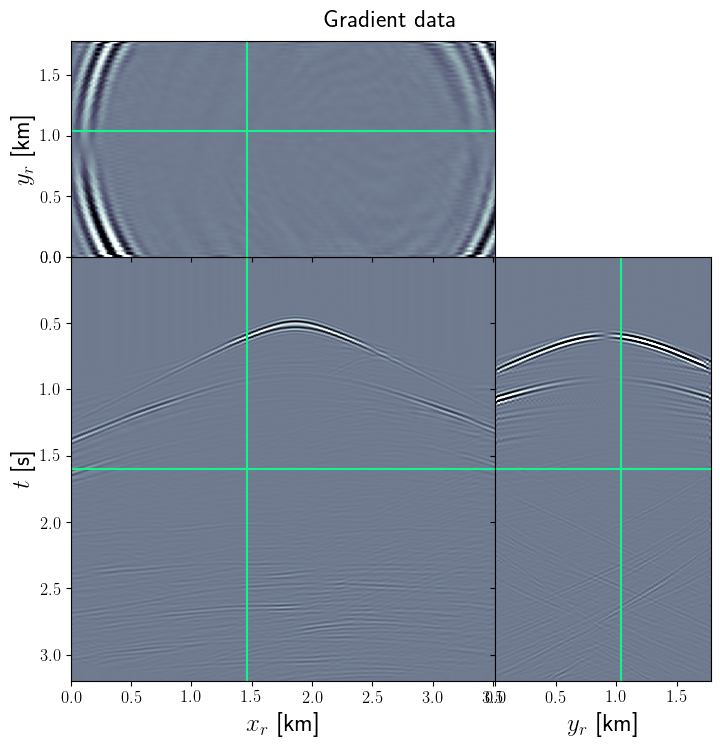

In [9]:
accy, _, scaccy, _, Fop, D1op, D2op, D, D1, _, kys, kxs, f = \
    gradient_data3d(p, nfft_y, nfft_x, nfft_t, dy, dx, dt, dtype=np.complex64)\

# Decimate data
pdec = np.real(Rop * p.ravel())
accydec = np.real(Rop * accy.ravel())

explode_volume(accy.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.05, 0.05), figsize=(8, 8), 
               title='Gradient data');

## FK mask design

Finally we design an FK mask that will be used to precondition all reconstruction processes, such that we ensure the reconstruct spectrum to lie within the expected signal cone.

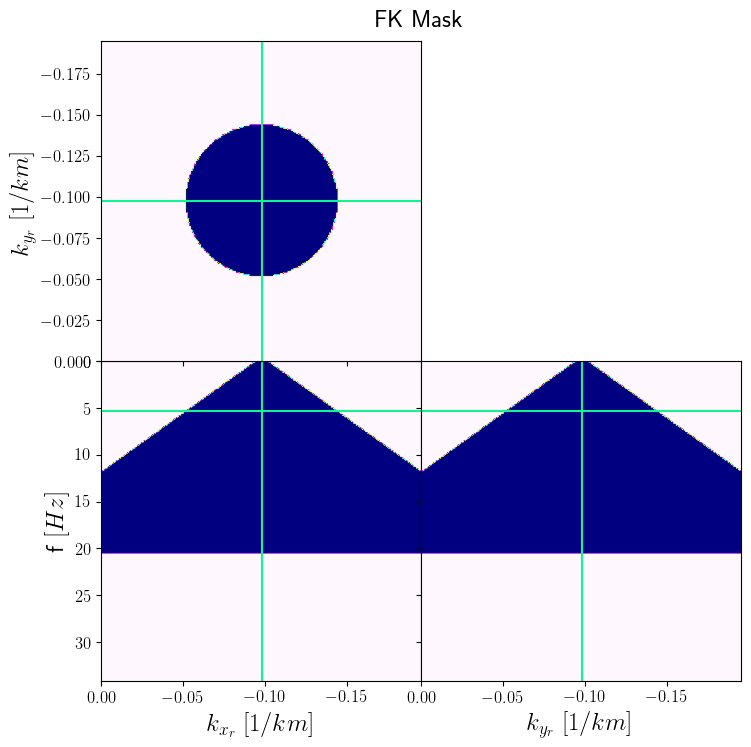

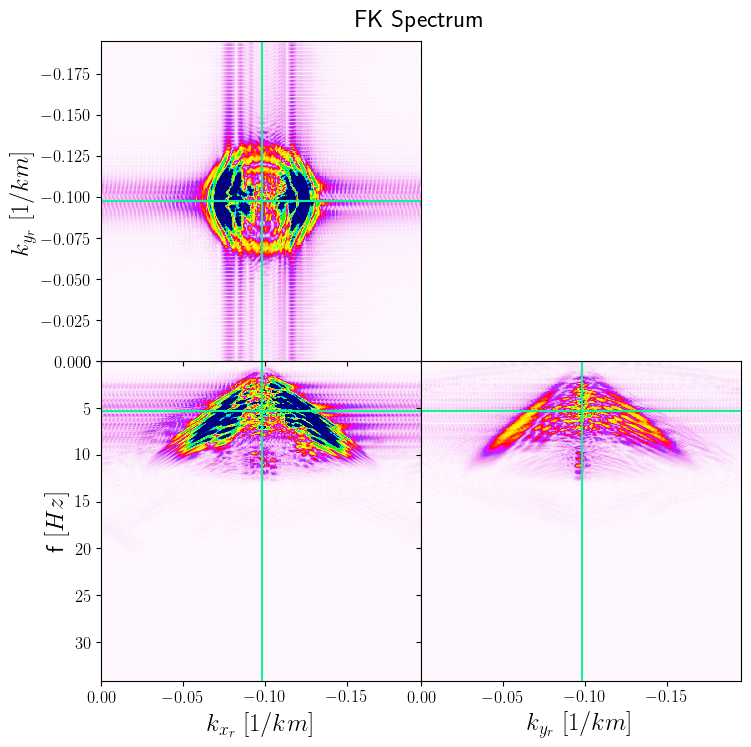

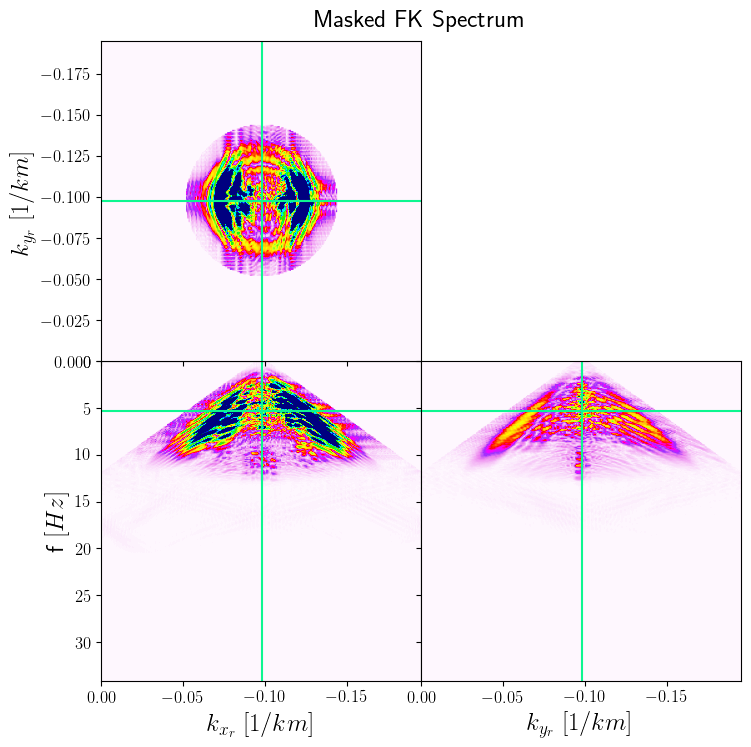

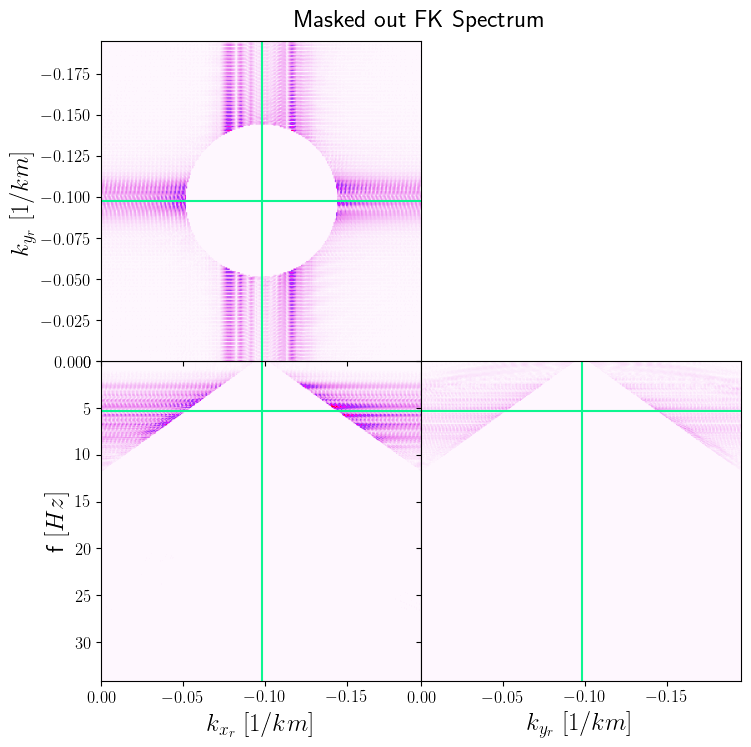

In [10]:
mask_fk = fk_filter_design3d(f, kys, kxs, vel, fmax, critical=critical, koffset=koffset)
Mf = Diagonal(cp_asarray(mask_fk).ravel().astype(np.float32), dtype=np.complex64)

ifmax = 140
explode_volume(np.fft.fftshift(mask_fk, axes=(0,1)).transpose(2, 1, 0), t=80,
               tlim=[0,f[ifmax]], tlabel='f',
               xlim=[1e3*kxs[0], 1e3*kxs[-1]], xlabel=r'$k_{x_r}$',
               ylim=[1e3*kys[0], 1e3*kys[-1]], ylabel=r'$k_{y_r}$',
               labels= (r'$[Hz]$', r'$[1/km]$', r'$[1/km]$'),                   
               cmap='gist_ncar_r', figsize=(8, 8), 
               clipval=(0, 1.), title='FK Mask')

explode_volume(np.fft.fftshift(np.abs(D), axes=(0,1)).transpose(2, 1, 0), t=80,
               tlim=[0,f[ifmax]], tlabel='f',
               xlim=[1e3*kxs[0], 1e3*kxs[-1]], xlabel=r'$k_{x_r}$',
               ylim=[1e3*kys[0], 1e3*kys[-1]], ylabel=r'$k_{y_r}$',
               labels= (r'$[Hz]$', r'$[1/km]$', r'$[1/km]$'),                   
               cmap='gist_ncar_r', figsize=(8, 8), 
               clipval=(0, 2.), title='FK Spectrum')

explode_volume(np.fft.fftshift(np.abs(mask_fk * D), axes=(0,1)).transpose(2, 1, 0), t=80,
               tlim=[0,f[ifmax]], tlabel='f',
               xlim=[1e3*kxs[0], 1e3*kxs[-1]], xlabel=r'$k_{x_r}$',
               ylim=[1e3*kys[0], 1e3*kys[-1]], ylabel=r'$k_{y_r}$',
               labels= (r'$[Hz]$', r'$[1/km]$', r'$[1/km]$'),                   
               cmap='gist_ncar_r', figsize=(8, 8), 
               clipval=(0, 2.), title='Masked FK Spectrum')

explode_volume(np.fft.fftshift(np.abs((1 - mask_fk) * D), axes=(0,1)).transpose(2, 1, 0), t=80,
               tlim=[0,f[ifmax]], tlabel='f',
               xlim=[1e3*kxs[0], 1e3*kxs[-1]], xlabel=r'$k_{x_r}$',
               ylim=[1e3*kys[0], 1e3*kys[-1]], ylabel=r'$k_{y_r}$',
               labels= (r'$[Hz]$', r'$[1/km]$', r'$[1/km]$'),                   
               cmap='gist_ncar_r', figsize=(8, 8), 
               clipval=(0, 2.), title='Masked out FK Spectrum');

## Slope estimation

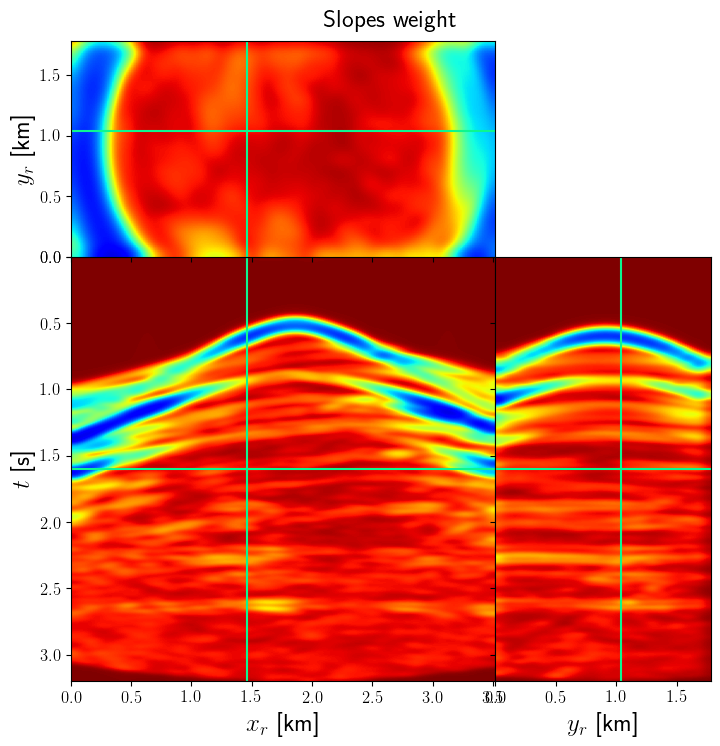

In [11]:
# Compute weight to encorage the slope of weak events to appear at early stage of inversion
weight = 1./(sp.ndimage.gaussian_filter(np.abs(sp.signal.hilbert(p_mask.data)), sigma=3) + 1e-1)

explode_volume(weight.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'), cmap='jet',
               clipval=(0, 10), figsize=(8, 8), 
               title='Slopes weight');

In [12]:
Ft = FirstDerivative((ny, nx, nt), axis=2, sampling=dt, order=5, edge=True)
data_dy = cp_asarray(accy).astype(np.float32)
data_dt = cp_asarray(Ft * p).astype(np.float32)

Wop = Diagonal(cp_asarray(weight[::nsub]).astype(np.float32))
Ddt = Diagonal(cp_asarray(Rop @ data_dt).astype(np.float32))
Lop = Laplacian((ny, nx, nt), sampling=(1, 1, 1), axes=(0, 1, 2), weights=(1, 1, 1))

slope_mc1 = regularized_inversion(Wop @ Ddt @ Rop, - (Wop @ Rop @ data_dy).ravel(), 
                                  [Lop], epsRs=[eps_slopeest], **dict(niter=niter_slopeest, show=True))[0]
slope_mc1 = cp_asnumpy(slope_mc1).reshape(ny, nx, nt)

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 2551986 rows and 12759930 cols
Regs=[<12759930x12759930 LinearOperator with dtype=float64>]
epsRs=[600.0]
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 15311916 rows and 12759930 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 400
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        4.6531e-33         3.6696e+01     3.6696e+01
     2        1.0182e-32         3.6014e+01     3.6014e+01
     3        1.6479e-32         3.5431e+01     3.5431e+01
     4        2.3569e-32         3.4794e+01     3.4794e+01
     5        2.9313e-32         3.4154e+01     3.4154e+01
     6        3.1334e-32         3.3644e+01     3.3644e+01
     7        2.9366e-32         3.3307e+01     3.3307e+01
     8    

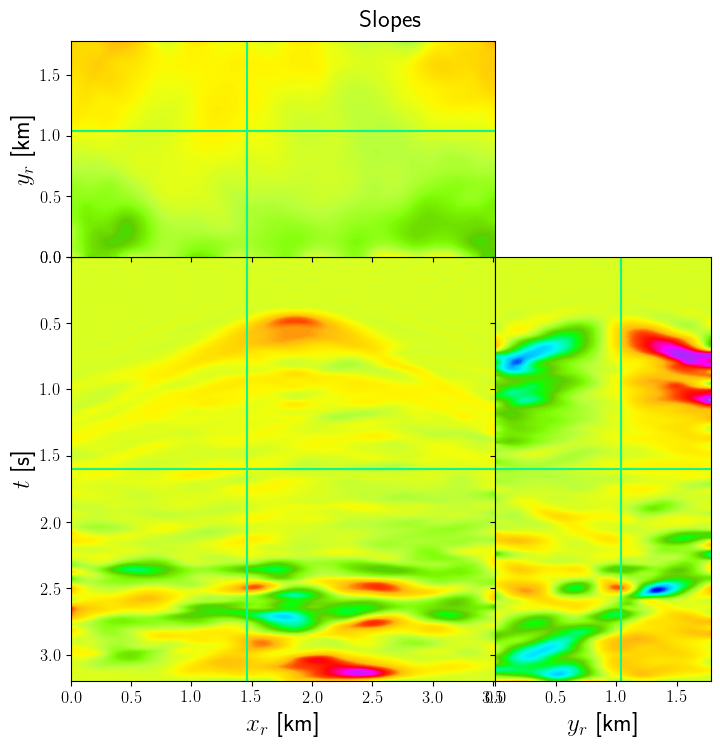

In [13]:
explode_volume(slope_mc1.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'), cmap='gist_ncar',
               clipval=(-1/vel, 1/vel), figsize=(8, 8),
               title='Slopes');

## Sparse inversion with FK sparsity transform and frequency domain masks

In [14]:
F0op = Rop * Fop.H * Mf
data0 = cp_asarray(pdec.astype(np.float32))

with disabled_ndarray_multiplication():
    pinv0, _, _ = fista(F0op, data0.ravel(), niter=niter, eps=eps_fk, 
                        eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv0 = cp_asnumpy(np.real(Fop.H * Mf * pinv0)).reshape(ny, nx, nt)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 2551986 rows and 33619968 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 200
alpha = 1.097085e+00	thresh = 5.485426e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    4.518e+04   5.019e+04   4.771e+02
     2   0.00e+00+0.00e+00j    1.515e+04   2.199e+04   2.062e+02
     3   0.00e+00+0.00e+00j    4.821e+03   1.272e+04   1.377e+02
     4   0.00e+00+0.00e+00j    1.649e+03   1.008e+04   8.697e+01
     5   0.00e+00+0.00e+00j    6.850e+02   9.338e+03   5.469e+01
     6   0.00e+00+0.00e+00j    3.641e+02   9.085e+03   3.589e+01
     7   0.00e+00+0.00e+00j    2.556e+02   8.974e+03   2.472e+01
     8   0.00e+00+0.00e+00j    2.264e+02   8.915e+03   1.729e+01
     9   0.00e+00+0.00e+00j    2.170e+02   8.867e+03   1.282e+01
    10   0.00e+00+

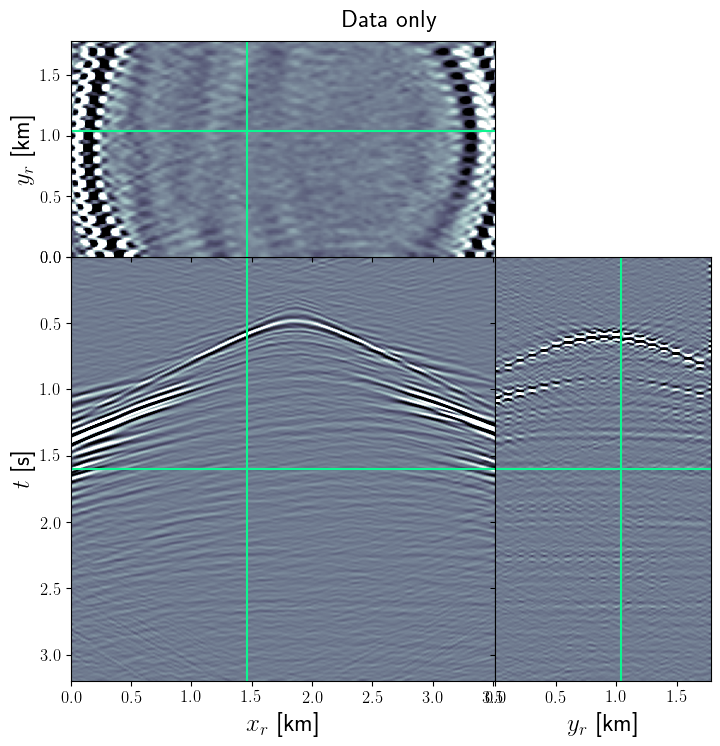

In [15]:
explode_volume(dinv0.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title='Data only');

## Sparse inversion with FK sparsity transform, frequency domain masks, and gradient

In [16]:
F1op = VStack([Rop*Fop.H, 
               scaccy*Rop*Fop.H*D1op,]) * Mf
data1 = cp_asarray(np.concatenate((pdec, scaccy*accydec), axis=0).astype(np.float32))

pinv1, _, _ = fista(F1op, data1, niter=niter, eps=eps_fk, 
                    eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv1 = cp_asnumpy(np.real(Fop.H * Mf * pinv1)).reshape(ny, nx, nt)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 5103972 rows and 33619968 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 200
alpha = 2.134807e-01	thresh = 1.067403e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    2.008e+05   2.023e+05   1.206e+02
     2   0.00e+00+0.00e+00j    1.597e+05   1.623e+05   9.706e+01
     3   0.00e+00+0.00e+00j    1.223e+05   1.260e+05   1.052e+02
     4   0.00e+00+0.00e+00j    9.080e+04   9.552e+04   1.076e+02
     5   0.00e+00+0.00e+00j    6.572e+04   7.146e+04   1.057e+02
     6   0.00e+00+0.00e+00j    4.668e+04   5.337e+04   1.007e+02
     7   0.00e+00+0.00e+00j    3.276e+04   4.028e+04   9.379e+01
     8   0.00e+00+0.00e+00j    2.287e+04   3.111e+04   8.581e+01
     9   0.00e+00+0.00e+00j    1.595e+04   2.479e+04   7.754e+01
    10   0.00e+00+

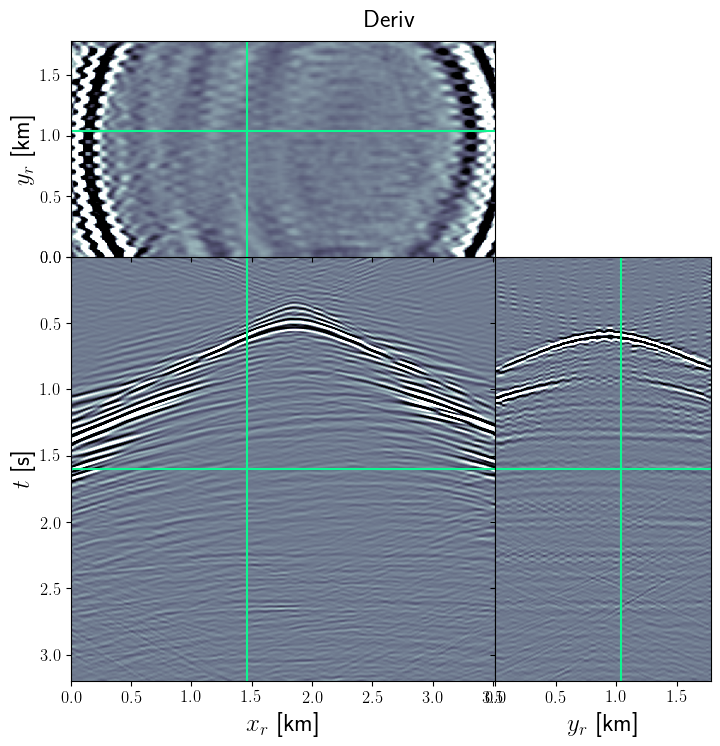

In [17]:
explode_volume(dinv1.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title='Deriv');

## Sparse inversion with FK sparsity transform, frequency domain masks, and gradient+slopes

In [18]:
# Let's start by setting the slope regularization term
D1op0 = FirstDerivative(dims=(ny, nx, nt), axis=0, sampling=dy, order=5, edge=True, dtype="complex64")
D1op1 = FirstDerivative(dims=(ny, nx, nt), axis=2, sampling=dt, order=5, edge=True, dtype="complex64")

slope_D1op1 = Diagonal(cp_asarray(slope_mc1.ravel()).astype(np.float32)) * D1op1
SRegop = D1op0 + slope_D1op1

In [19]:
F2op = VStack([Rop*Fop.H, 
               scaccy*Rop*Fop.H*D1op,
               eps_slopes * SRegop * Fop.H]) * Mf
data2 = cp_asarray(np.concatenate((pdec, scaccy*accydec, np.zeros(nt*ny*nx)), axis=0).astype(np.float32))

pinv2, _, _ = fista(F2op, data2, niter=niter, eps=eps_fk, 
                    eigsdict=dict(niter=5, tol=1e-2), show=True)
dinv2 = cp_asnumpy(np.real(Fop.H * Mf * pinv2)).reshape(ny, nx, nt)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 17863902 rows and 33619968 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 200
alpha = 1.961184e-01	thresh = 9.805922e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    2.065e+05   2.078e+05   1.108e+02
     2   0.00e+00+0.00e+00j    1.701e+05   1.724e+05   8.765e+01
     3   0.00e+00+0.00e+00j    1.373e+05   1.405e+05   9.452e+01
     4   0.00e+00+0.00e+00j    1.098e+05   1.141e+05   9.626e+01
     5   0.00e+00+0.00e+00j    8.781e+04   9.299e+04   9.459e+01
     6   0.00e+00+0.00e+00j    7.057e+04   7.659e+04   9.102e+01
     7   0.00e+00+0.00e+00j    5.707e+04   6.383e+04   8.670e+01
     8   0.00e+00+0.00e+00j    4.636e+04   5.376e+04   8.236e+01
     9   0.00e+00+0.00e+00j    3.775e+04   4.571e+04   7.828e+01
    10   0.00e+00

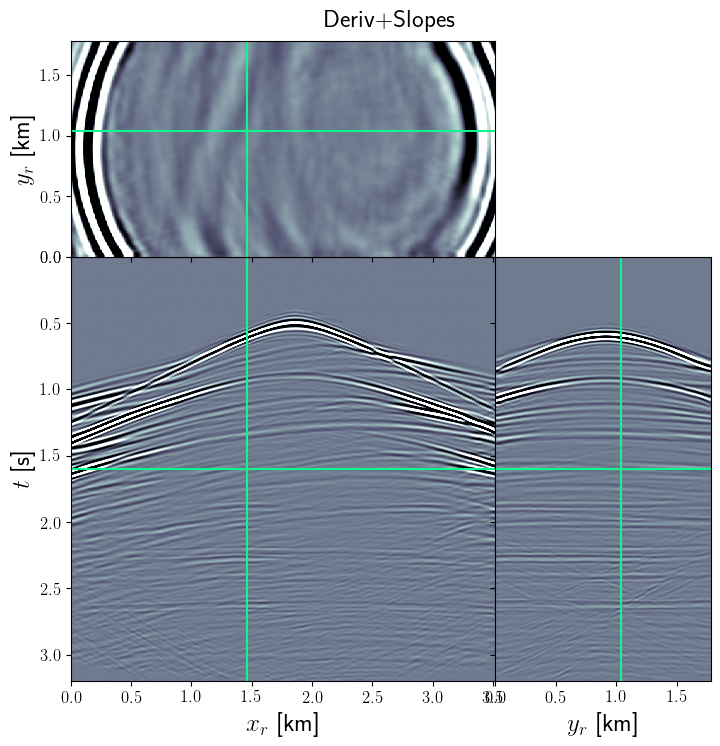

In [20]:
explode_volume((direct_mask*dinv2).transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title='Deriv+Slopes');

## Restore data (aka INMO correction)

Finally, if NMO correction was applied to the data prior to interpolation, we restore the data to their original domain

In [21]:
if apply_nmo:
    p = NMOOp.div(p.ravel(), niter=5).reshape(p.shape)
    p_mask = NMOOp.div(p_mask.data.ravel(), niter=5).reshape(p.shape)
    dinv0 = NMOOp.div(dinv0.ravel(), niter=5).reshape(p.shape)
    dinv1 = NMOOp.div(dinv1.ravel(), niter=5).reshape(p.shape)
    dinv2 = NMOOp.div(dinv2.ravel(), niter=5).reshape(p.shape)

## Comparison

In [22]:
snr_pmask = snr(p, p_mask)
snr_dinv0 = snr(p, direct_mask*dinv0)
snr_dinv1 = snr(p, direct_mask*dinv1)
snr_dinv2 = snr(p, direct_mask*dinv2)

0.9788540797328459 2.4346604147113897 3.8454456189294888 17.633785789184255


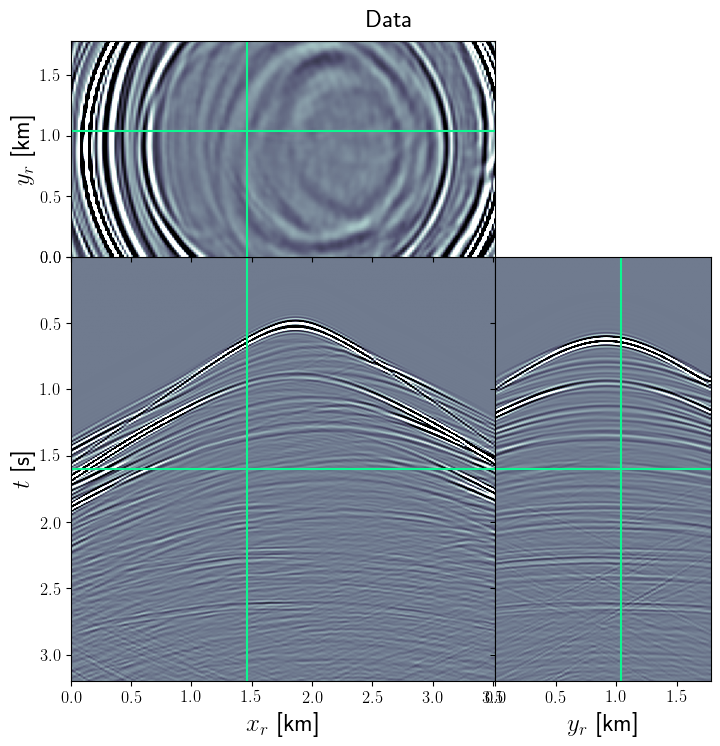

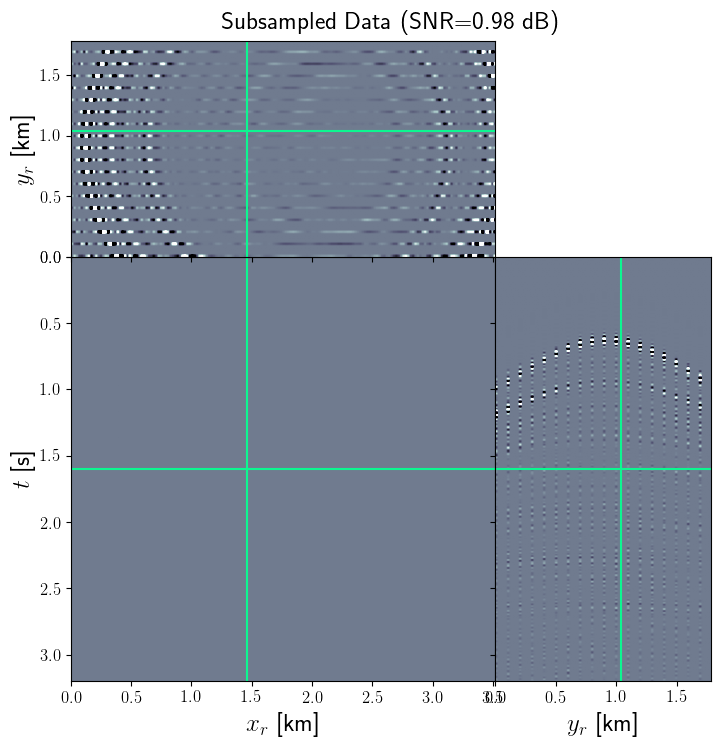

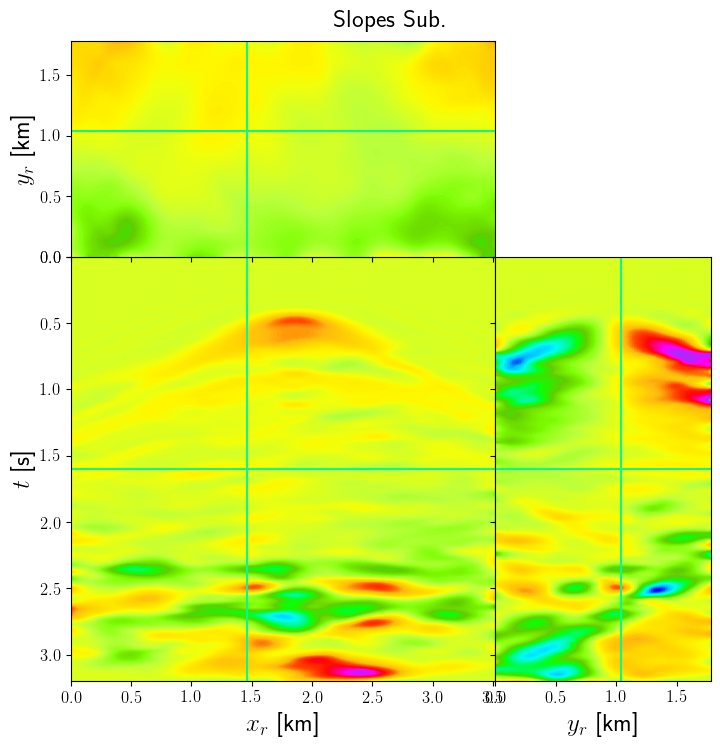

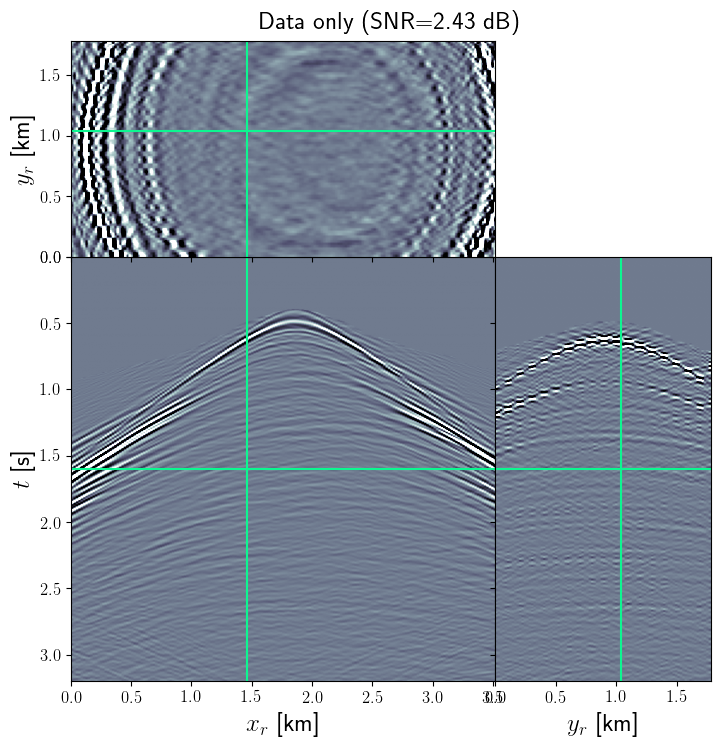

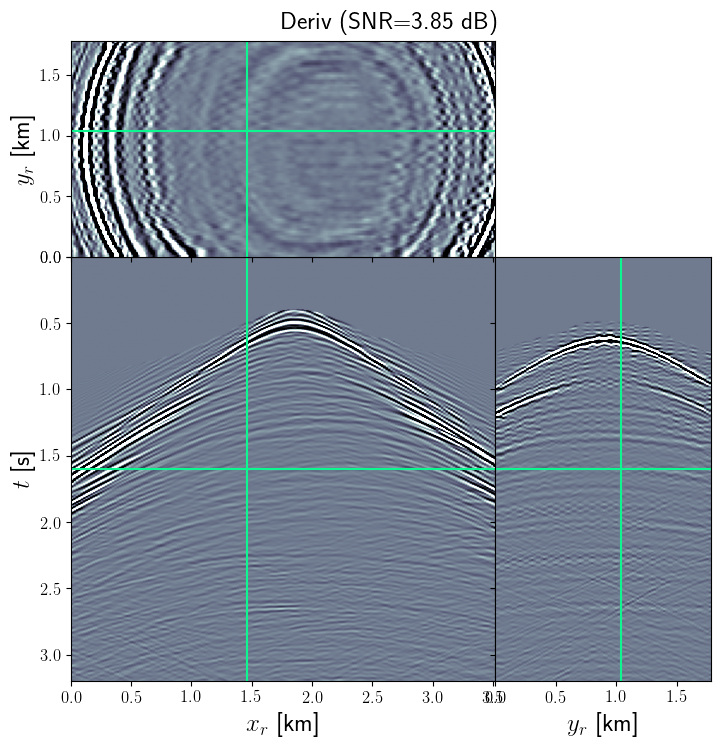

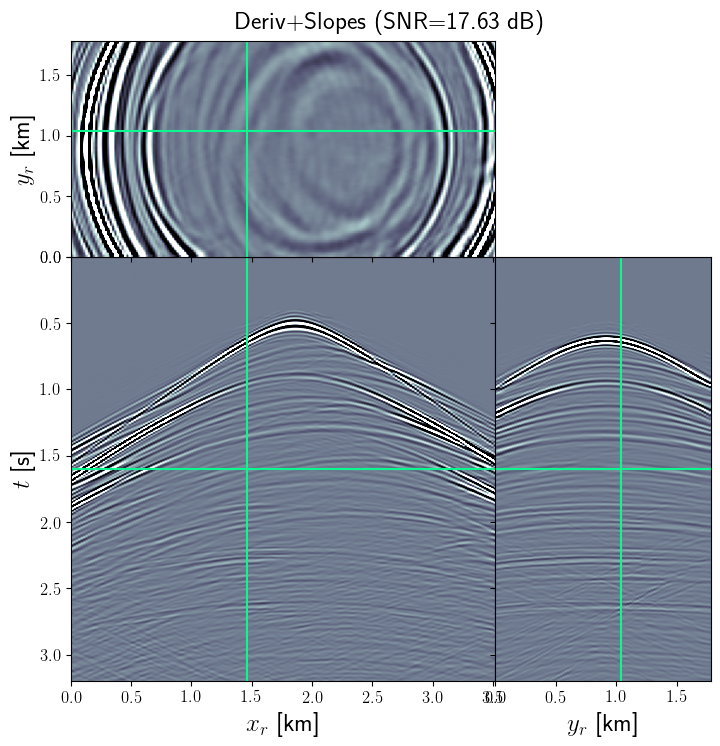

In [24]:
explode_volume(p.transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Data')

explode_volume(p_mask.transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Subsampled Data (SNR={snr(p, p_mask):.2f} dB)')

explode_volume(slope_mc1.transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-1/vel, 1/vel), figsize=(8, 8), cmap='gist_ncar',
               title=f'Slopes Sub.')

explode_volume((direct_mask*dinv0).transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Data only (SNR={snr_dinv0:.2f} dB)')

explode_volume((direct_mask*dinv1).transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Deriv (SNR={snr_dinv1:.2f} dB)')

explode_volume((direct_mask*dinv2).transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Deriv+Slopes (SNR={snr_dinv2:.2f} dB)');